In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from msdlib import mlutils, msd
from IPython.core.display import HTML
import os
import time
from PIL import Image

C:\Users\abdul\Anaconda3\envs\torchenv\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\abdul\Anaconda3\envs\torchenv\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
C:\Users\abdul\Anaconda3\envs\torchenv\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.options.display.max_columns = None

In [3]:
data_dir = 'E:\\Data sets\\MNIST'
gen_input_size = 128
batch_size = 256
epoch = 100
learning_rate = .0001
K = 1
gen_step = 2
gen_gamma = .9
disc_step = 2
disc_gamma = .9
sample_interval = 500
device = 'cuda'

In [4]:
data = pd.read_csv(os.path.join(data_dir, 'train.csv'))
data

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,pixel249,pixel250,pixel251,pixel252,pixel253,pixel254,pixel255,pixel256,pixel257,pixel258,pixel259,pixel260,pixel261,pixel262,pixel263,pixel264,pixel265,pixel266,pixel267,pixel268,pixel269,pixel270,pixel271,pixel272,pixel273,pixel274,pixel275,pixel276,pixel277,pixel278,pixel279,pixel280,pixel281,pixel282,pixel283,pixel284,pixel285,pixel286,pixel287,pixel288,pixel289,pixel290,pixel291,pixel292,pixel293,pixel294,pixel295,pixel296,pixel297,pixel298,pixel299,pixel300,pixel301,pixel302,pixel303,pixel304,pixel305,pixel306,pixel307,pixel308,pixel309,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319,pixel320,pixel321,pixel322,pixel323,pixel324,pixel325,pixel326,pixel327,pixel328,pixel329,pixel330,pixel331,pixel332,pixel333,pixel334,pixel335,pixel336,pixel337,pixel338,pixel339,pixel340,pixel341,pixel342,pixel343,pixel344,pixel345,pixel346,pixel347,pixel348,pixel349,pixel350,pixel351,pixel352,pixel353,pixel354,pixel355,pixel356,pixel357,pixel358,pixel359,pixel360,pixel361,pixel362,pixel363,pixel364,pixel365,pixel366,pixel367,pixel368,pixel369,pixel370,pixel371,pixel372,pixel373,pixel374,pixel375,pixel376,pixel377,pixel378,pixel379,pixel380,pixel381,pixel382,pixel383,pixel384,pixel385,pixel386,pixel387,pixel388,pixel389,pixel390,pixel391,pixel392,pixel393,pixel394,pixel395,pixel396,pixel397,pixel398,pixel399,pixel400,pixel401,pixel402,pixel403,pixel404,pixel405,pixel406,pixel407,pixel408,pixel409,pixel410,pixel411,pixel412,pixel413,pixel414,pixel415,pixel416,pixel417,pixel418,pixel419,pixel420,pixel421,pixel422,pixel423,pixel424,pixel425,pixel426,pixel427,pixel428,pixel429,pixel430,pixel431,pixel432,pixel433,pixel434,pixel435,pixel436,pixel437,pixel438,pixel439,pixel440,pixel441,pixel442,pixel443,pixel444,pixel445,pixel446,pixel447,pixel448,pixel449,pixel450,pixel451,pixel452,pixel453,pixel454,pixel455

In [5]:
dimension = int((data.shape[1] - 1)**.5)
if torch.cuda.is_available() and device == 'cuda':
    device = 'cuda'
else:
    device= ' cpu'

In [6]:
label = data['label'].values.copy()
data.drop('label', axis=1, inplace=True)
data = ((data.values / 255) - .5) * 2
data.shape

(42000, 784)

In [20]:
class Generator(torch.nn.Module):
    
    def __init__(self, input_shape=256, dimension=28):
        super(Generator, self).__init__()
        self.input_shape = input_shape
        self.dimension = dimension
        
        self.model = self.define_model()
        
    def define_model(self):
        
        self.lin1 = torch.nn.Linear(self.input_shape, 512)
        self.relu1 = torch.nn.LeakyReLU()
        self.bn1 = torch.nn.BatchNorm1d(512)
        self.lin2 = torch.nn.Linear(512, 1024)
        self.relu2 = torch.nn.LeakyReLU()
        self.bn2 = torch.nn.BatchNorm1d(1024)
        self.lin3 = torch.nn.Linear(1024, 256)
        self.relu3 = torch.nn.LeakyReLU()
        self.bn3 = torch.nn.BatchNorm1d(256)
        self.lin4 = torch.nn.Linear(256, self.dimension**2)
    
    def forward(self, x):
        x = self.relu1(self.bn1(self.lin1(x)))
        x = self.relu2(self.bn2(self.lin2(x)))
        x = self.relu3(self.bn3(self.lin3(x)))
        x = torch.tanh(self.lin4(x))
        
        return x

In [21]:
class Discriminator(torch.nn.Module):
    
    def __init__(self, dimension=28, factor=4):
        super(Discriminator, self).__init__()
        self.dimension = dimension
        self.factor = factor
        
        self.model = self.define_model()
        
    def define_model(self):
        self.lin1 = torch.nn.Linear(self.dimension**2, 512)
        self.relu1 = torch.nn.ReLU()
        self.lin2 = torch.nn.Linear(512, 1)
        self.relu2 = torch.nn.ReLU()
        
    def forward(self, x):
        x = self.relu1(self.lin1(x))
        x = torch.sigmoid(self.lin2(x)).squeeze()
        return x

In [37]:
class GANTrainer():
    
    def __init__(self, K=1, dimension=28, gen_input_size=128, learning_rate=.0001, epoch=100, batch_size=64, 
                 gen_step=1, gen_gamma=1, disc_step=1, disc_gamma=1, sample_intv=500, device='cuda', dtype=torch.float32):
        
        self.K_rev = np.ceil(1/K)
        self.K = np.ceil(K)
        self.dimension = dimension
        self.gen_input_size = gen_input_size
        self.lr = learning_rate
        self.epoch = epoch
        self.batch_size = batch_size
        self.dtype = dtype
        self.device = device
        self.gen_step = gen_step
        self.gen_gamma = gen_gamma
        self.disc_step = disc_step
        self.disc_gamma = disc_gamma
        self.sample_intv = sample_intv
        
        self.gen = Generator(input_shape=self.gen_input_size, dimension=self.dimension).to(device=self.device, dtype=self.dtype)
        self.disc = Discriminator(dimension=dimension).to(device=self.device, dtype=self.dtype)
        
        self.set_optimizer()
    
    def set_optimizer(self):
        self.gen_opt = torch.optim.Adam(self.gen.parameters(), lr=self.lr, betas=(.5, .999))
        self.disc_opt = torch.optim.Adam(self.disc.parameters(), lr=self.lr, betas=(.5, .999))
        self.gen_sch = torch.optim.lr_scheduler.StepLR(self.gen_opt, self.gen_step, self.gen_gamma, verbose=False)
        self.disc_sch = torch.optim.lr_scheduler.StepLR(self.disc_opt, self.disc_step, self.disc_gamma, verbose=False)
        
    def train(self, data, label):
        
        data = torch.tensor(data, device=self.device, dtype=self.dtype)
        data_loader = torch.utils.data.DataLoader(data, batch_size=self.batch_size, shuffle=True)
        
        self.losses = {'gen': [], 'disc': []}
        k = 0
        
        self.total_batch = len(data_loader)
        t1 = time.time()
        cnt = 0
        self.disc.train()
        for ep in range(self.epoch):
            _genloss = []
            _discloss = []
            gen_loss = 0
            
            gendata = np.random.random(size=(data.shape[0], self.gen_input_size))
            gendata = torch.tensor(gendata, device=self.device, dtype=self.dtype).squeeze()
            gen_loader = torch.utils.data.DataLoader(gendata, batch_size=self.batch_size, shuffle=True)
            
            for i, (batch_gendata, batch_data) in enumerate(zip(gen_loader, data_loader)):
                self.gen.train()
                if k % self.K_rev == 0:
                    # discriminator loss
                    self.disc.zero_grad()
                    g_out = self.gen(batch_gendata).detach()
                    d_data = self.disc(batch_data)
                    d_g = self.disc(g_out)

                    disc_loss = - torch.mean(torch.log(d_data) + torch.log(1 - d_g))
                    _discloss.append(disc_loss.item())
                    disc_loss.backward()
                    self.disc_opt.step()
                
                if k % self.K == 0:
                    # generator loss
                    self.gen.zero_grad()
                    g_out = self.gen(batch_gendata)
                    d_g = self.disc(g_out)

                    gen_loss = torch.mean(torch.log(1 - d_g))
                    _genloss.append(gen_loss.item())
                    gen_loss.backward()
                    self.gen_opt.step()
                
                if cnt % self.sample_intv == 0:
                    self.save_sample(ep, i)
                k += 1
                cnt += 1
                
                time_string = msd.get_time_estimation(time_st=t1, current_ep=ep, current_batch=i, total_ep=self.epoch, total_batch=self.total_batch)
                print('\repoch : %04d/%04d, batch : %03d, generator_loss : %.4f, discriminator_loss : %.4f,  %s'
                      % (ep + 1, self.epoch, i + 1, gen_loss, disc_loss, time_string)+' '*20, end='', flush=True)
            
                self.losses['gen'].append(gen_loss.item())
                self.losses['disc'].append(disc_loss.item())
            self.gen_sch.step()
            self.disc_sch.step()
    
    def generate(self, N_sample):
        self.gen.eval()
        gendata = np.random.random(size=(N_sample, self.gen_input_size))
        gendata =  torch.tensor(gendata, device=self.device, dtype=self.dtype).squeeze()
        g_out = self.gen(gendata)
        g_out = g_out.view(-1, dimension, dimension)
        g_out = ((g_out / 2) + .5) * 255
        return g_out
    
    def plot_learning_curve(self):
        losses = pd.DataFrame(self.losses, index=np.arange(len(self.losses['gen'])) / self.total_batch)
        same_srs = [losses[c] for c in losses.columns]
        msd.plot_time_series(same_srs=same_srs, show=True, segs=1)
    
    def save_sample(self, ep, batch):
        os.makedirs('samples', exist_ok=True)
        out = self.generate(20)
        A = [[] for _ in range(5)]
        for i in range(5):
            for j in range(4):
                A[i].append(out[i*4+j].detach().cpu().numpy().astype(int))
            A[i] = np.concatenate(A[i], axis=1)
        A = np.concatenate(A, axis=0)
        im = Image.fromarray(A).convert('RGB')
        im.save("samples/epoch-%d_batch-%d.jpg"%(ep, batch))


In [38]:
trainer = GANTrainer(K=K, dimension=dimension, gen_input_size=gen_input_size, learning_rate=learning_rate, epoch=epoch, batch_size=batch_size,
                     gen_step=gen_step, gen_gamma=gen_gamma, disc_step=disc_step, disc_gamma=disc_gamma, sample_intv=sample_interval, device=device)

epoch : 0100/0100, batch : 165, generator_loss : -0.5222, discriminator_loss : 1.0415,  0:08:22 < 0:00:00                    

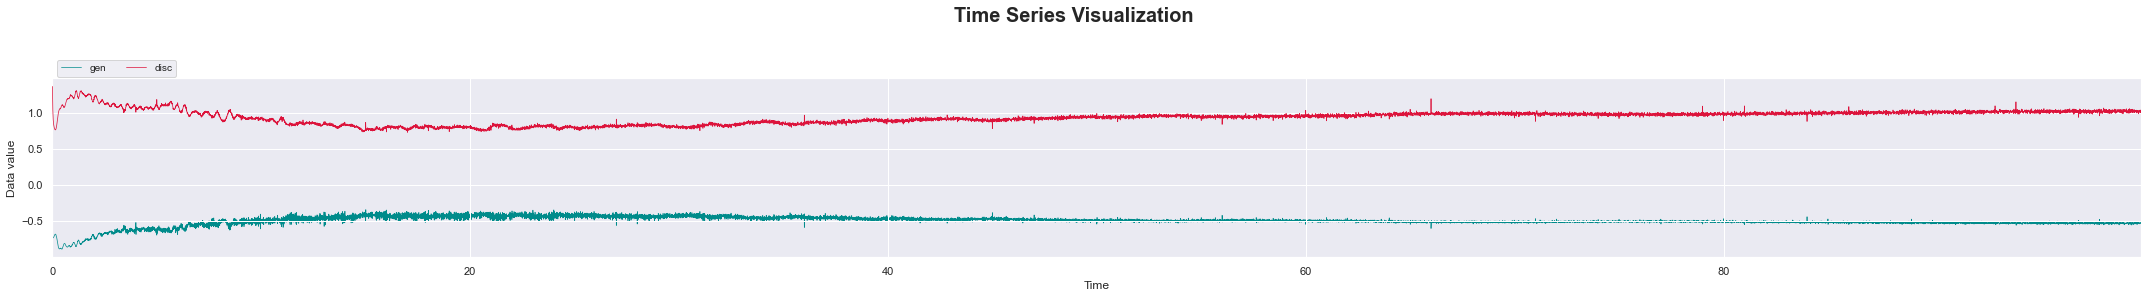

In [39]:
try:
    trainer.train(data, label)
    trainer.plot_learning_curve()
except KeyboardInterrupt:
    trainer.plot_learning_curve()

In [40]:
out = trainer.generate(10).detach().cpu().numpy()

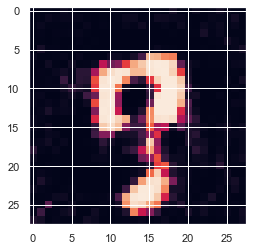

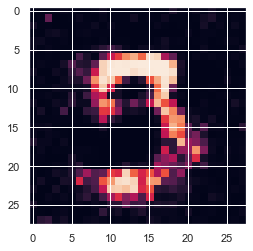

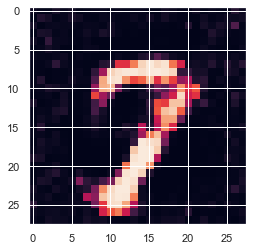

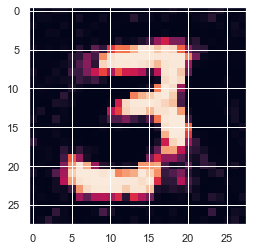

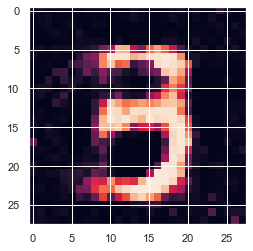

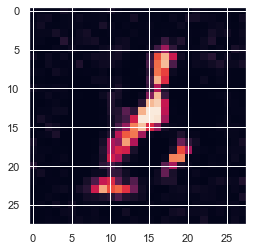

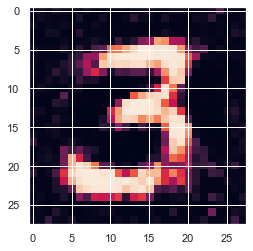

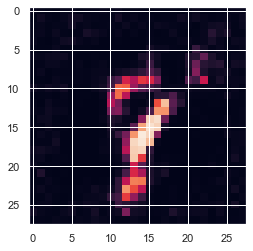

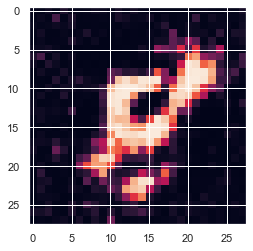

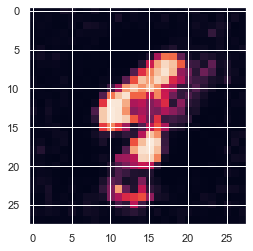

In [42]:
for i in range(len(out)):
    plt.Figure()
    plt.imshow(out[i])
    plt.show()